In this notebook I will apply the LSTM model into the data which was prepared in R.

### 1. Importing the libraries

In [75]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [18]:
fludat_pivot = pd.read_csv('./dataset/Flu_pivot.csv')

In [19]:
fludat_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sdate      546 non-null    object
 1   Processed  546 non-null    int64 
 2   A_total    546 non-null    int64 
 3   B_total    546 non-null    int64 
 4   All_total  546 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 21.5+ KB


In [20]:
fludat_pivot['sdate'] = pd.to_datetime(fludat_pivot['sdate'])

In [21]:
fludat_pivot.head()

,sdate,Processed,A_total,B_total,All_total
0,2010-01-04,9312,1999,1,2000
1,2010-01-11,10728,1404,15,1419
2,2010-01-18,9027,1135,49,1184
3,2010-01-25,8030,515,18,533
4,2010-02-01,7788,502,14,516


In [25]:
forecast_data = fludat_pivot.set_index(fludat_pivot['sdate'])['All_total']

In [33]:
forecast_data.name = 'Positive_cases'

In [35]:
forecast_data

sdate
2010-01-04    2000
2010-01-11    1419
2010-01-18    1184
2010-01-25     533
2010-02-01     516
              ... 
2020-05-18       3
2020-05-25       3
2020-06-01       1
2020-06-08       4
2020-06-15       0
Name: Positive_cases, Length: 546, dtype: int64

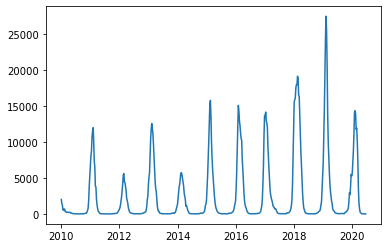

In [29]:
plt.plot(forecast_data)

In [38]:
 # LSTM are sensitive to the scale of the data, so we apply minmax scaler
    
scaler = MinMaxScaler(feature_range=(0,1))

# Scaled array
forecast_data_scaled = scaler.fit_transform(np.array(forecast_data).reshape(-1,1))

In [45]:
# Splitting the dataset into train and test 80% - 20%

train_size = int(len(forecast_data_scaled)*0.8)
test_size = len(forecast_data_scaled)-train_size

training_data = forecast_data_scaled[0:train_size,:]
test_data = forecast_data_scaled[train_size:len(forecast_data_scaled),:]

In [53]:
# Within the 'training_data' and 'test_data', we create x_train,x_test, y_train, y_test

def create_data(dataset, time_step = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        data_X.append(a)
        data_Y.append(dataset[i + time_step, 0])
    return np.array(data_X), np.array(data_Y)

In [108]:
# time_step hyperparameter tuning
time_step = 5

X_train, y_train = create_data(training_data, time_step)
X_test, y_test = create_data(test_data, time_step)

In [109]:
print('X_train shape: ',X_train.shape, ', y_train shape: ',y_train.shape)
print('------------------------')
print('X_test shape: ',X_test.shape, ', y_test shape: ',y_test.shape)

X_train shape:  (430, 5) , y_train shape:  (430,)
------------------------
X_test shape:  (104, 5) , y_test shape:  (104,)


### LSTM model

In [110]:
# for LSTM we need to add an additional dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [111]:
# Create stack LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [112]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [113]:
EPOCHS = 50
H = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = EPOCHS, batch_size = 32, verbose = 1)

Epoch 1/50
14/14 [==============================] - 6s 101ms/step - loss: 0.0275 - val_loss: 0.0386
Epoch 2/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0153 - val_loss: 0.0285
Epoch 3/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0112 - val_loss: 0.0298
Epoch 4/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0108 - val_loss: 0.0276
Epoch 5/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0119 - val_loss: 0.0280
Epoch 6/50
14/14 [==============================] - 0s 9ms/step - loss: 0.0101 - val_loss: 0.0267
Epoch 7/50
14/14 [==============================] - 0s 9ms/step - loss: 0.0098 - val_loss: 0.0257
Epoch 8/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0086 - val_loss: 0.0255
Epoch 9/50
14/14 [==============================] - 0s 9ms/step - loss: 0.0097 - val_loss: 0.0244
Epoch 10/50
14/14 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0218
Epoch 11/50


In [114]:
# Prediction
y_pred = model.predict(X_test)

In [115]:
y_pred_realval = scaler.inverse_transform(y_pred)

In [116]:
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
lstm_rmse

0.04745117267778421

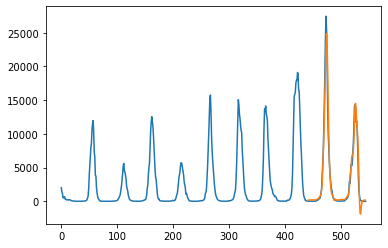

In [117]:
# plotting
look_back = 5
test_predict = np.empty_like(forecast_data_scaled)
test_predict[:,:] = np.nan
test_predict[len(X_train) + (look_back*2)+1 : len(forecast_data_scaled)-1, :] = y_pred_realval
plt.plot(scaler.inverse_transform(forecast_data_scaled))
plt.plot(test_predict)
plt.show()

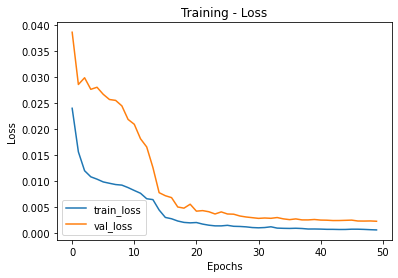

In [118]:
N = EPOCHS

plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.title('Training - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig("./plot/LSTM_model_training_plot.png")

This is a good model, not over and underfitted.

### Predicting for 2 years (104 weeks)

In [120]:
len(test_data)

110

In [139]:
# We need the last 5 value from the test data to start the prediction
x_input = test_data[len(test_data)-5:].reshape(1,-1)

# x_input to list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()


# find next 104 value
output = []
time_step = 5
i = 0

while(i<104):
    if(len(temp_input)>5):
        # last 5 element after the first loop
        x_input = np.array(temp_input[1:])
        #reshaping
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape(1, time_step, 1)
        # predict
        y_hat = model.predict(x_input, verbose = 0)
        # adding to the temp list
        temp_input.append(y_hat[0][0].tolist())
        # change temp list to the last 5 value
        temp_input = temp_input[1:]
        # add prediction to output
        output.append(y_hat[0][0].tolist())
        i = i+1
    
    else:
        # last 5 value reshape and predict
        x_input = x_input.reshape(1, time_step, 1)
        y_hat = model.predict(x_input, verbose = 0)
        
        # adding the value to temp input list
        temp_input.append(y_hat[0][0].tolist())
        # adding the value to output list
        output.append(y_hat[0][0].tolist())
        i = i+1

print(output)

[0.006939306389540434, 0.012598161585628986, 0.022669196128845215, 0.037247300148010254, 0.057227786630392075, 0.08324230462312698, 0.11816228181123734, 0.1616498976945877, 0.2136305719614029, 0.2712876796722412, 0.3286057412624359, 0.3771117031574249, 0.4097318947315216, 0.42377838492393494, 0.42166000604629517, 0.40803512930870056, 0.38718393445014954, 0.36215466260910034, 0.3349825441837311, 0.30701500177383423, 0.2791815996170044, 0.2521817088127136, 0.22659428417682648, 0.20292939245700836, 0.1816529482603073, 0.16319283843040466, 0.14793655276298523, 0.13622872531414032, 0.1283753663301468, 0.12465202808380127, 0.12531164288520813, 0.13058020174503326, 0.14062577486038208, 0.15548592805862427, 0.17494451999664307, 0.1983664482831955, 0.22453300654888153, 0.25156939029693604, 0.27708491683006287, 0.2985893189907074, 0.3140798509120941, 0.32251739501953125, 0.3239375948905945, 0.31919237971305847, 0.309542179107666, 0.2963199317455292, 0.2807464301586151, 0.2638673186302185, 0.2465

In [155]:
y_pred_2yrs = scaler.inverse_transform(np.array(output).reshape(-1,1))

In [158]:
len(forecast_data)

546

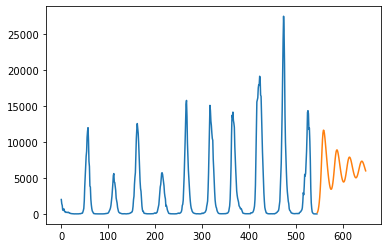

In [159]:
plt.plot(np.arange(0,546),forecast_data)
plt.plot(np.arange(546,546+104),y_pred_2yrs)